In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('cleaned_transactions.csv')
df.head()

,transaction_id,user_id,transaction_date,amount,payment_method,device,payment_status,failure_reason,retry_count,recovered_flag,recovery_status,revenue_lost,revenue_recovered,retry_bucket
0,1,1860,2024-05-24,1324.34,Debit Card,iOS,success,no_failure,0,0,success,0.00,0.0,no_retry
1,2,4772,2024-04-04,2237.72,Credit Card,iOS,success,no_failure,0,0,success,0.00,0.0,no_retry
2,3,4092,2024-02-02,3190.09,Debit Card,Web,success,no_failure,0,0,success,0.00,0.0,no_retry
3,4,1466,2024-02-25,940.45,Credit Card,Android,failed,network_error,0,0,lost,940.45,0.0,no_retry
4,5,5426,2024-05-04,3846.30,Credit Card,Web,success,no_failure,0,0,success,0.00,0.0,no_retry


Failed Transactions

In [3]:
failed_df = df[df['payment_status'] == 'failed']
failed_df.shape

(4581, 14)

Retry Distribution

In [4]:
retry_distribution = (
    failed_df['retry_count']
    .value_counts()
    .sort_index()
    .reset_index()
)

retry_distribution.columns = ['retry_count', 'failed_transactions']
retry_distribution

,retry_count,failed_transactions
0,0,1831
1,1,1397
2,2,899
3,3,454


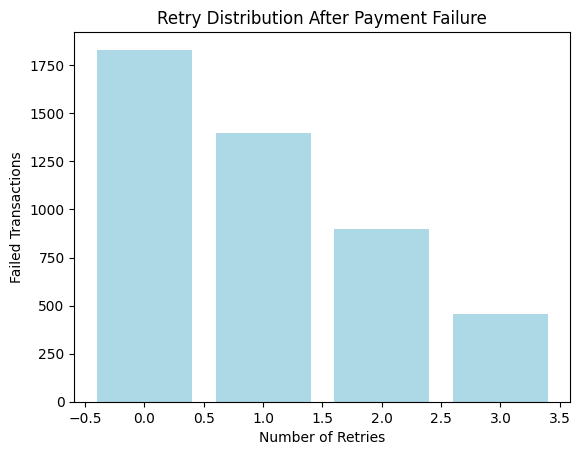

In [5]:
plt.figure()
plt.bar(retry_distribution['retry_count'],
        retry_distribution['failed_transactions'],color='lightblue')
plt.title('Retry Distribution After Payment Failure')
plt.xlabel('Number of Retries')
plt.ylabel('Failed Transactions')
plt.show()

Recovery Rate by Retry

In [6]:
recovery_by_retry = (
    failed_df
    .groupby('retry_count')
    .agg(
        total_failed=('transaction_id', 'count'),
        recovered=('recovered_flag', 'sum')
    )
    .reset_index()
)

recovery_by_retry['recovery_rate_pct'] = (
    recovery_by_retry['recovered'] / recovery_by_retry['total_failed'] * 100
)

recovery_by_retry

,retry_count,total_failed,recovered,recovery_rate_pct
0,0,1831,0,0.000000
1,1,1397,787,56.335004
2,2,899,495,55.061179
3,3,454,254,55.947137


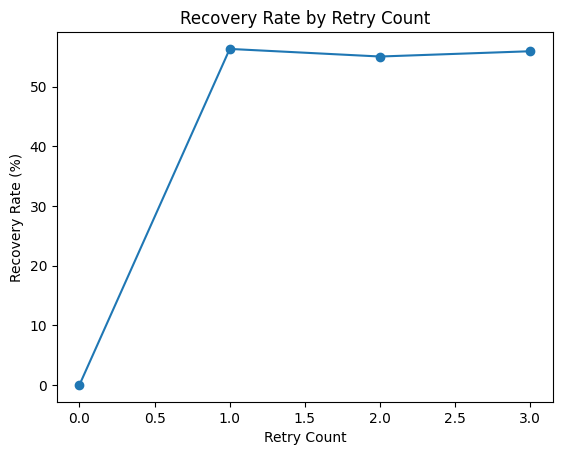

In [7]:
plt.figure()
plt.plot(recovery_by_retry['retry_count'],
         recovery_by_retry['recovery_rate_pct'],
         marker='o')
plt.title('Recovery Rate by Retry Count')
plt.xlabel('Retry Count')
plt.ylabel('Recovery Rate (%)')
plt.show()

Retry Behaviour

In [8]:
retry_reason = (
    failed_df
    .groupby(['failure_reason', 'retry_bucket'])
    .size()
    .reset_index(name='count')
)

retry_reason

,failure_reason,retry_bucket,count
0,bank_decline,1_retry,220
1,bank_decline,2_retries,134
2,bank_decline,3_retries,68
3,bank_decline,no_retry,271
4,insufficient_funds,1_retry,397
5,insufficient_funds,2_retries,286
6,insufficient_funds,3_retries,142
7,insufficient_funds,no_retry,580
8,network_error,1_retry,484
9,network_error,2_retries,308


From the above output we can say:

1.Most users retry 0–1 times

2.Recovery improves significantly after first retry

3.Beyond 2 retries, recovery gain is marginal

4.Certain failure reasons recover better (e.g., network errors)